# Sequências - Aula Prática

## RNNs (Recurrent Neural Networks)

Neste notebook iremos trabalhar com a abordagem inicial de redes neurais recorrentes (RNNs), implementando do zero uma RNN utilizando PyTorch. Além disso, iremos usar RNNs para para realizar uma classificação de litologia.

- **Importante:** caso esteja rodando esse notebook no ambiente da Tatu, favor executar a próxima célula. Caso contrário, basta ignorar a sua execução.

In [ ]:
data_dir = '/pgeoprj/godeep/dados/l2_datasets/publico/force'

# Configuração do ambiente



### Importação de pacotes
Esta seção importa várias bibliotecas Python necessárias para processamento de dados, treinamento de modelos e avaliação. As principais importações incluem:
- **Manipulação de dados:** `pandas`, `numpy` e `os`.
- **Utilitários de aprendizado de máquina:** `scikit-learn` para pré-processamento, métricas e divisão de dados.
- **Modelagem e treinamento:** `pytorch` para implementação de modelo de aprendizado profundo.
- **Visualização:** `matplotlib` para plotagem.
- **Registro e utilitários:** `tqdm` para barras de progresso e `glob` para gerenciamento de arquivos.

### Configurações
Um estado aleatório fixo (`random_state = 42`) é definido para reprodutibilidade entre experimentos.

A configuração do dispositivo garante o uso da GPU, se disponível, com um fallback para a CPU.


In [ ]:
import os

import json
import pandas as pd
from tqdm import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, balanced_accuracy_score

import torch
import random

import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device escolhido:', device)

random_state = 42

Device escolhido: cuda


### Configuração do modelo

A classe `CFG` define as configurações para o modelo de classificação de litologia. Os principais parâmetros incluem:
- **Detalhes do modelo:** Tipo de modelo (`'RNN'`) e tamanho da sequência (por exemplo, `256`).
- **Configurações de treinamento:** Número de épocas, tamanho do lote e taxa de aprendizado.
- **Divisão de dados:** Tipo de divisão (`'train_val_test'`) e proporções (`test_size = 0,2`, `val_size = 0,1`).
- **Método de dimensionamento:** Dimensionamento padrão ou dimensionamento Min-Max (`'standard' ou 'min-max'`).
- **Detalhes do conjunto de dados:** Caminhos para dados de registro de poços e coluna de destino para classificação de litologia.
- **Informações da classe:** Número de classes de litologia (Força: `11`).
- **Detalhamento:** Configurações de *logging*.

In [ ]:
class CFG:
    model = 'RNN'
    seq_size = 256
    weighted = True

    epochs = 100
    batch_size = 64
    lr = 0.0001

    split_form = 'train_val_test' ## kfold, train_test or train_val_test
    n_splits = 5
    test_size = 0.2
    val_size = 0.1
    shuffle = True

    scaling_method = 'standard' # standard or min-max

    data_dir = data_dir
    logs = ['GR', 'RHOB', 'NPHI', 'DTC']
    logs_info = logs + ['WELL', 'DEPTH_MD', 'LITHOLOGY']
    class_col = 'LITHOLOGY'

    num_classes = 11

    verbose = True

cfg = CFG()

# Carregamento da base de dados

### Definição da classe Force

A classe `Force` foi projetada para lidar com o carregamento e o pré-processamento inicial de dados de registro de poços para classificação de litologia. O conjunto de dados FORCE vem de uma competição feita em 2020.

Abaixo estão os detalhes de sua implementação:

#### **Inicialização de classe (método `__init__`)**
- **Parâmetros:**
- `directory`: Caminho para o diretório de dados.
- `logs`: Uma lista de registros a serem usados dataset FORCE.
- `verbose`: Se `True`, imprime detalhes adicionais durante a execução.
- **Chaves de litologia:** Um dicionário que mapeia códigos numéricos de litologia para seus respectivos nomes.

#### **Carregamento de dados (método `open_data`)**
- **Objetivo:** Método principal para abrir, mesclar e pré-processar dados de registro de poço.
- **Retorna:**
- Um `pandas.DataFrame` contendo dados de registro de poço.
- Uma instância `LabelEncoder` para codificar rótulos de litologia em valores numéricos de 0 a num_classes-1.

**Principais etapas:**
1. **Carregamento de dados:** Lê vários arquivos CSV (`train.csv`, `hidden_test.csv`, `leaderboard_test_features.csv`, etc.) em DataFrames separados.
2. **Verificações de consistência de dados:** Garante valores correspondentes para as colunas `WELL` e `DEPTH_MD` entre dataframes concatenados.
3. **Manipulação de valores ausentes:** Preenche valores ausentes na coluna `FORCE_2020_LITHOFACIES_CONFIDENCE` com `NaN`.
4. **Concatenação e redefinição de índice:** Mescla vários conjuntos de dados (`train`, `leaderboard_test`, etc.) em um DataFrame consolidado e redefine o índice.
5. **Codificação de rótulos:** mapeia códigos de litologia para seus nomes usando `lithology_keys` e os codifica como inteiros usando `LabelEncoder`.

**Saída:**
- O conjunto de dados pré-processado (`data`) e o codificador de rótulo (`le`) são retornados para uso subsequente no pipeline de modelagem.


In [ ]:
class Force:

    def __init__(self, directory:str, logs:list[str], verbose:bool=False) -> None:
        """
            Arguments:
            ---------
                - directory (str): Path to the directory where data is
                - logs (list[str] or tuple[str]): Logs used from FORCE data
                - verbose (bool): If True, print progress details. Else, does not print anything.
        """

        self.directory = directory
        self.logs = logs

        self.lithology_keys = {30000: 'Sandstone',
                     65030: 'Sandstone/Shale',
                     65000: 'Shale',
                     80000: 'Marl',
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}

        self.data, self.le = self.open_data()


    def open_data(self) -> tuple[pd.DataFrame, LabelEncoder]:

        """
        Main method to open data.
            Arguments:
            ---------
                -
            Return:
            ---------
                - data (pd.DataFrame): Well log dataset fully configured to be used
                - le (LabelEncoder): Label Encoder used to encode lithology classes to consecutive numbers
        """

        train_data = pd.read_csv( os.path.join(self.directory, 'train.csv'), sep=';' )
        hidden_test = pd.read_csv( os.path.join(self.directory, 'hidden_test.csv'), sep=';' )
        leaderboard_test_features = pd.read_csv( os.path.join(self.directory, 'leaderboard_test_features.csv'), sep=';' )
        leaderboard_test_target = pd.read_csv( os.path.join(self.directory, 'leaderboard_test_target.csv'), sep=';' )


        ## A little of consistency checking
        leaderboard_test_target['WELL_tg'] = leaderboard_test_target.WELL
        leaderboard_test_target['DEPTH_MD_tg'] = leaderboard_test_target.DEPTH_MD
        leaderboard_test_target.drop(columns=['WELL', 'DEPTH_MD'], inplace=True)
        leaderboard_test = pd.concat([leaderboard_test_features, leaderboard_test_target], axis=1)

        ## Make sure the values for the WELL and DEPTH_MD columns match between the two concatenated data-frames
        _check_well = np.all( (leaderboard_test.WELL == leaderboard_test.WELL_tg).values )
        _check_depth = np.all( (leaderboard_test.DEPTH_MD == leaderboard_test.DEPTH_MD_tg).values )
        assert _check_well and _check_depth, 'Inconsistency found in leaderboard test data...'

        ## Passed the consistency check, we drop the redundant columns
        leaderboard_test.drop(columns=['WELL_tg', 'DEPTH_MD_tg'], inplace=True)

        ## Note leaderboard_test dataframe does not have the FORCE_2020_LITHOFACIES_CONFIDENCE column. We will therefore fill it with NaNs.
        leaderboard_test['FORCE_2020_LITHOFACIES_CONFIDENCE'] = np.nan


        data = pd.concat([train_data, leaderboard_test, hidden_test], axis=0, ignore_index=True)
        data.sort_values(by=['WELL', 'DEPTH_MD'], inplace=True)
        data.reset_index(drop=True, inplace=True)


        #data['NPHI'] = np.log(data['NPHI'])
        data['LITHOLOGY_NAMES'] = data.FORCE_2020_LITHOFACIES_LITHOLOGY.map(self.lithology_keys)
        data = data[data["LITHOLOGY_NAMES"] != 'Basement']
        le = LabelEncoder()
        data['LITHOLOGY'] = le.fit_transform(data['FORCE_2020_LITHOFACIES_LITHOLOGY'])

        return data, le

# Pré-processamento

## Funções

### Winsorization of Well Log Data (`remove_quartiles` function)
Esta função remove outliers em dados de registro de poços cortando valores com base em quantis superiores e inferiores.

#### **Saída**
- Um DataFrame (`data`) com outliers removidos para os registros especificados.

In [ ]:
def remove_quartiles(original_data:pd.DataFrame, logs:list[str], q:list=[0.01, 0.99], verbose:bool=True) -> pd.DataFrame:
    """
    Function to apply winsorization (remove outliers by clipping extreme quartiles. Upper or lower quartiles)
        Arguments:
        ---------
            - original_data (pd.DataFrame): Well log data, including lithology column
            - logs (list[str]): List of log names used. Ex: GR, NPHI, ...
            - class_col (str): Name of the lithology column
        Return:
        ---------
            - data (pd.DataFrame): Well log data without outliers.
    """

    data = original_data.copy()
    num_cols = len(logs)

    for i, col in enumerate(logs):
        if verbose:
            print(f'Handling log {i + 1}/{num_cols} - {col}')
        array_data = data[col].values
        only_nans = np.all( np.isnan(array_data) )

        if not only_nans:
            min_quart, max_quart = np.nanquantile(array_data, q=q)

            if verbose:
                print(f'{col}: min: {min_quart:.4f} - max: {max_quart:.4f} ')

            # Set outlier values as nan
            outlier_idx = np.logical_or(array_data < min_quart, array_data > max_quart)
            if verbose:
                print(f'Ignoring {np.sum(outlier_idx)} values')

            # Set series in dataframe with clipped values
            data[col] = data[col].clip(min_quart, max_quart)

    if verbose:
        print()

    return data

### Abrir e pré-processar dados de registro de poço (função `open_and_preprocess_data`)
Esta função carrega, pré-processa e divide dados de registro de poço para treinamento, validação e teste.

#### **Processo**
1. **Carregamento de dados:** Usa a classe `Force` para carregar e pré-processar dados.
2. **Winsorization:** Remove outliers dos registros de poço usando `remove_quartiles`.
3. **Divisão de poço:** Divide poços em conjuntos de treinamento, validação e teste com base em tamanhos especificados.

#### **Saída**
- `data`: DataFrame pré-processado.
- `le`: Codificador de rótulo para classes de litologia.
- `well_names`: Lista de todos os nomes de poço.
- `train_wells`, `val_wells`, `test_wells`: Listas de poços para treinamento, validação e teste.


In [ ]:
def open_and_preprocess_data(data_dir:str, logs:list[str], class_col:str, test_size:float, val_size:float, shuffle:bool, random_state:int|np.random.RandomState, verbose:bool=True) -> tuple[pd.DataFrame, LabelEncoder, list, list, list]:

    """
    Function that receives all necessary parameters to open and preprocess data and calls all necessary functions, classes and methods.
        Arguments:
        ---------
            - data_dir (str): Path for folder containing dataset.
            - logs (str): List of names of logs used.
            - class_col (str): Name of the label column (usually 'Lithology')
            - test_size (float): Size of test set. Range: 0-1.
            - val_size (float): Size of validation set. Range: 0-1.
            - shuffle (bool): Wether to shuffle or not while data splitting.
            - random_state (int or np.random.RandomState): Random state to define random operations.
            - verbose (bool): If True, print progress details. Else, does not print anything.
        Return:
        ---------
            - data (pd.DataFrame): Well log dataset fully configured to be used
            - le (LabelEncoder): Label Encoder used to encode lithology classes to consecutive numbers
            - well_names (list[str]): List of all well names contained in dataset
            - train_wells (list[str]): List of train wells after splitting
            - val_wells (list[str] or None): List of validation wells after splitting. Can be None if there is no validation split.
            - test_wells (list[str] or None): List of test wells after splitting. Can be None if there is no test split.
    """

    force_dataset = Force(data_dir, logs)
    data, le = force_dataset.data, force_dataset.le

    data = remove_quartiles(data, logs, verbose=verbose)

    well_names = list(data['WELL'].unique())
    train_wells, test_wells = train_test_split(well_names, test_size=test_size, shuffle=shuffle, random_state=random_state)
    train_wells, val_wells = train_test_split(train_wells, test_size=val_size, shuffle=shuffle, random_state=random_state)


    return data, le, well_names, train_wells, val_wells, test_wells

## Pipeline de pré-processamento de dados
Esta seção usa a função `open_and_preprocess_data` para carregar e preparar dados para o aprendizado de máquina:
1. Carrega o conjunto de dados com remoção de outliers habilitada.
2. Divide os dados em conjuntos de treinamento, validação e teste com base em nomes de poços.
3. Atribui dados de entrada (`X`) e rótulos de destino (`y`) para cada divisão.
4. Normaliza valores de log de poços usando `StandardScaler`.

#### **Saídas de dados**
- `X_train`, `y_train`: Dados de treinamento e rótulos.
- `X_val`, `y_val`: Dados de validação e rótulos.
- `X_test`, `y_test`: Dados de teste e rótulos.

Este pipeline garante pré-processamento consistente e prepara o conjunto de dados para modelagem.

In [ ]:
data, le_data, well_names, train_wells, val_wells, test_wells = open_and_preprocess_data(cfg.data_dir, cfg.logs, cfg.class_col,
                                                                                   cfg.test_size, cfg.val_size, cfg.shuffle,
                                                                                   random_state, verbose=cfg.verbose)

Handling log 1/4 - GR
GR: min: 8.9536 - max: 180.3104 
Ignoring 28592 values
Handling log 2/4 - RHOB
RHOB: min: 1.6196 - max: 2.6975 
Ignoring 24838 values
Handling log 3/4 - NPHI
NPHI: min: 0.0491 - max: 0.6245 
Ignoring 19320 values
Handling log 4/4 - DTC
DTC: min: 60.0862 - max: 173.0303 
Ignoring 26878 values



In [ ]:
train_data = data[data['WELL'].isin(train_wells)]
X_train = train_data[cfg.logs_info]
y_train = train_data[cfg.class_col]

val_data = data[data['WELL'].isin(val_wells)]
X_val = val_data[cfg.logs_info]
y_val = val_data[cfg.class_col]

test_data = data[data['WELL'].isin(test_wells)]
X_test = test_data[cfg.logs_info]
y_test = test_data[cfg.class_col]

In [ ]:
scaler = StandardScaler()

X_train[cfg.logs] = scaler.fit_transform(X_train[cfg.logs])
X_val[cfg.logs] = scaler.transform(X_val[cfg.logs])
X_test[cfg.logs] = scaler.transform(X_test[cfg.logs])

<ipython-input-12-36ac85b6a544>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cfg.logs] = scaler.fit_transform(X_train[cfg.logs])
<ipython-input-12-36ac85b6a544>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[cfg.logs] = scaler.transform(X_val[cfg.logs])
<ipython-input-12-36ac85b6a544>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

# Dataset e DataLoader

### Classe LithologyDataset
Esta classe é um conjunto de dados PyTorch personalizado projetado para classificação de litologia. Ele processa dados de registro de poços, gera sequências e prepara os dados para treinamento do modelo.

#### **Criando sequências (método `_create_dataset`)**
- **Objetivo:** Gera sequências de comprimento fixo (`seq_size`) a partir dos dados para cada poço.
- **Processo:**
1. Itera por cada poço no conjunto de dados.
2. Extrai sequências consecutivas de tamanho `seq_size`.
3. Lida com valores ausentes pulando sequências com NaNs.
4. Acrescenta sequências válidas junto com seus rótulos à lista de sequências.
- **Saída:** Uma lista de sequências sem valores ausentes.

#### **Tamanho do conjunto de dados (método `__len__`)**
- **Objetivo:** Retorna o número total de sequências no conjunto de dados.

#### **Obter item (método `__getitem__`)**
- **Objetivo:** Recupera uma única sequência e seus rótulos correspondentes com base no índice.

### Funcionalidade geral
A classe `LithologyDataset`:
1. Prepara dados de registro de poços para classificação de litologia.
2. Lida com geração de sequência, valores ausentes e formatação.
3. Fornece estruturas de dados compatíveis com PyTorch para treinamento de modelos de aprendizado de máquina.


In [ ]:
class LithologyDataset(Dataset):
    def __init__(self, df:pd.DataFrame, labels:pd.Series, logs:list[str], num_classes:int, seq_size:int=100, interval_size:int=100, well_name_column:str='WELL', lithology_column:str='LITHOLOGY') -> None:
        """
            Arguments:
            ---------
                - df (pd.DataFrame): Well log data
                - labels (pd.Series): Column containing lithology classes for each depth
                - logs (list[str]): List of logs used. Ex: GR, NPHI, ...
                - num_classes (int): Number of lithology classes
                - seq_size (int): Size of sequence sent to the model
                - interval_size (int): Size of the interval used to extract consecutive sequences
                - well_name_column (str): Name of the column that indicates the well name in the data
                - lithology_column (str): Name of the lithology column
            Return:
            ---------
                None
        """

        self.data = df
        self.list_of_wells = list(df[well_name_column].unique())
        self.labels = labels
        self.logs = logs
        self.num_classes = num_classes
        self.seq_size = seq_size
        self.interval_size = interval_size
        self.well_name_column = well_name_column
        self.lithology_column = lithology_column
        self.no_missing_logs = self.logs + [self.lithology_column]

        self.data['labels'] = labels
        self.list_of_sequences = self.__create_dataset(self.data, verbose=False)

    def __create_dataset(self, df:pd.DataFrame, verbose:bool=False) -> list:
        """
            Arguments:
            ---------
                - df (pd.DataFrame): Well log data
            Return:
            ---------
                - list_of_sequences (list): list of all sequences without null values in the dataset
        """

        list_of_sequences = list()

        for wellname in tqdm(self.list_of_wells, disable=(not verbose)):

            well_df = df[df[self.well_name_column] == wellname]

            j=0
            while j < well_df.shape[0]-(self.seq_size-1): # Enquanto for possível pegar uma sequência de tamanho seq_size no meu poço

                sequence = well_df.iloc[j:j+self.seq_size]

                # Busca indíces de valores nulos dentro da sequência
                idx_null = [k for k,x in enumerate(sequence[self.no_missing_logs].values) if np.isnan(x).any()]

                # Se não tiver valor nulo na sequência
                if idx_null == []:
                    list_of_sequences.append([wellname, sequence[self.logs], sequence['labels']])
                    j = j + self.interval_size
                # Se tiver, pular para o indíce seguinte ao último valor nulo na sequência
                else:
                    j = j + idx_null[-1] + 1

        return list_of_sequences

    def __len__(self):

        return len(self.list_of_sequences)

    def __getitem__(self, idx) -> tuple[str, torch.Tensor, torch.Tensor]:
        """
            Arguments:
            ---------
                - idx (int): Index for selecting a sample from the dataset
            Return:
            ---------
                - wellname (str): Name of the well from which the sequence is taken
                - well_data_torch (torch.Tensor): Well log sequence
                - labels_torch (torch.Tensor): One-hot-encoded lithology labels sequence
        """

        wellname, sequence, labels = self.list_of_sequences[idx]
        # To Numpy
        sequence_numpy = sequence.to_numpy()
        sequence_numpy = np.reshape(sequence_numpy, (-1, len(self.logs)))

        # Create one-hot vector to represent labels
        labels_numpy = np.array([np.array([1. if i==label else 0. for i in range(self.num_classes)]) for label in labels.to_numpy()])

        # To Torch
        well_data_torch = torch.from_numpy(sequence_numpy).float()
        labels_torch = torch.from_numpy(labels_numpy).float()

        return wellname, well_data_torch, labels_torch

### Criando Datasets e DataLoaders

Esta seção prepara os dados para treinamento, validação e teste utilizando a classe `LithologyDataset` e o `DataLoader` do PyTorch. Os DataLoaders facilitam o processamento em lote durante o treinamento e a avaliação do modelo.

#### **Datasets**
**Dataset de treinamento, validação ou teste (`{split_type}_dataset`)**:
- Entradas: `X_{split_type}`, `y_{split_type}` e parâmetros de configuração.
- As sequências são geradas usando a classe `LithologyDataset` com tamanho de sequência especificado (`cfg.seq_size`) e tamanho de intervalo.

#### **DataLoaders**
**DataLoader (`{split_type}_dataloader`)**:
- Envolve o `{split_type}_dataset` para processamento em lote eficiente.
- Tamanho do lote: `cfg.batch_size`.
- O embaralhamento habilitado (`shuffle=True`) garante a randomização durante o treinamento.

### Objetivo
Esta configuração garante:
1. Carregamento de dados eficiente e escalável para treinamento, validação e teste.
2. Compatibilidade com o loop de treinamento do PyTorch.
3. Manipulação adequada de sequências com tamanhos de lote configuráveis e embaralhamento de dados conforme necessário.


In [ ]:
train_dataset = LithologyDataset(X_train, y_train, cfg.logs, cfg.num_classes, seq_size=cfg.seq_size, interval_size=cfg.seq_size)
train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

val_dataset = LithologyDataset(X_val, y_val, cfg.logs, cfg.num_classes, seq_size=cfg.seq_size, interval_size=cfg.seq_size)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

test_dataset = LithologyDataset(X_test, y_test, cfg.logs, cfg.num_classes, seq_size=cfg.seq_size, interval_size=cfg.seq_size)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)

<ipython-input-13-33781b61fbc3>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['labels'] = labels
<ipython-input-13-33781b61fbc3>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['labels'] = labels
<ipython-input-13-33781b61fbc3>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

# Modelos

As classes a seguir implementam três tipos de redes neurais recorrentes (RNNs) usando PyTorch: RNN, LSTM e GRU. Cada classe é projetada para manipular dados sequenciais, como sequências de registros de poços, e inclui uma camada totalmente conectada para gerar saídas.

#### **Classe RNN**
- **Inicialização (`__init__`):**
    - Usa `nn.RNN` do PyTorch com parâmetros personalizáveis:
        - `input_size`: Número de atributos na entrada.
        - `hidden_size`: Número de unidades ocultas.
        - `num_layers`: Número de camadas RNN empilhadas (padrão: 2).
        - `bidirectional`: Se a RNN é bidirecional (padrão: True).
        - `batch_first`: Indica que a dimensão do lote vem primeiro na entrada.
    - Adiciona uma camada totalmente conectada (`nn.Linear`) para projeção de saída.
- **Passo para frente (`forward`):**
    - Processa a entrada por meio da RNN.
    - Aplica a camada totalmente conectada à saída da última camada.


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, batch_first=True, bidirectional=True):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.D = 2 if bidirectional else 1

        # PyTorch's built-in RNN
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=bidirectional,
            nonlinearity="tanh"  # Can be "tanh" or "relu"
        )
        self.fc = nn.Linear(self.D*hidden_size, output_size)  # Example output layer

    def forward(self, x):
        # Forward pass through RNN
        outputs, hidden_aux = self.rnn(x)

        # Pass final hidden state from the last layer to the output layer
        out = self.fc(outputs)  # Use all timesteps' output

        return out, hidden_aux

#### **Classe LSTM**
- Semelhante à classe RNN, mas usa `nn.LSTM` para modelagem de dependência de longo prazo.
- **Diferença principal:** Inclui estados ocultos e de célula para retenção de memória em sequências.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, batch_first=True, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.D = 2 if bidirectional else 1

        # PyTorch's built-in LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(self.D*hidden_size, output_size)  # Example output layer

    def forward(self, x):
        # Forward pass through LSTM
        outputs, (hidden_aux, cell_aux) = self.lstm(x)

        # Pass final hidden state from the last layer to the output layer
        out = self.fc(outputs)  # Use the last timestep's output
        return out, (hidden_aux, cell_aux)

#### **Classe GRU**
- Semelhante à classe LSTM, mas usa `nn.GRU`.
- **Diferença principal:** Combina estados ocultos e de célula em um único estado oculto para uma arquitetura mais simples.

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, batch_first=True, bidirectional=True):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.D = 2 if bidirectional else 1

        # PyTorch's built-in LSTM
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(self.D*hidden_size, output_size)  # Example output layer

    def forward(self, x):
        # Forward pass through LSTM
        outputs, hidden_aux = self.gru(x)
        #print(outputs.shape, hidden_aux.shape)

        # Pass final hidden state from the last layer to the output layer
        out = self.fc(outputs)  # Use the last timestep's output
        return out, hidden_aux

### Funcionalidade
- **Camadas recorrentes:** Modelagem sequencial central usando RNN, LSTM ou GRU.
- **Bidirecionalidade:** Melhora o desempenho processando sequências em direções para frente e para trás.
- **Camada de saída:** Projeta a saída RNN para a dimensão desejada (`output_size`).

Essas classes são modulares e podem ser usadas de forma intercambiável, dependendo dos requisitos do problema.

# Treinamento

### Função de avaliação (`evaluate`)
Avalia um modelo PyTorch treinado e calcula métricas de classificação.

#### **Processo**

1. Loop de previsão:

- Itera pelo DataLoader para prever rótulos de classe e extrair o rótulo verdadeiro (ground truth).


2. Cálculo de métricas:

- Calcula acurácia, MCC, precisão, recall e F1-score, se solicitado.
- Exibe uma matriz de confusão normalizada com rótulos de classe de litologia.

In [ ]:
def evaluate(model, dataloader, print_metrics=False):

    model.eval()
    y_pred_deep = []
    y_test_deep = []
    with torch.no_grad():

        for i, (wellnames, well_data_torch, labels_torch) in enumerate(dataloader):

            well_data_torch = well_data_torch.to(device)
            labels_torch = labels_torch.to(device)

            output, hidden = model(well_data_torch)

            # Reshape to 2D tensor (batch_size * seq_len, num_classes)
            output = output.reshape(-1, cfg.num_classes).detach().cpu().numpy()

            labels_torch = labels_torch.reshape(-1, cfg.num_classes).detach().cpu().numpy()

            test_probs = np.argmax(output, axis=1).tolist()
            test_labels = np.argmax(labels_torch, axis=1).tolist()

            y_pred_deep.extend(test_probs)
            y_test_deep.extend(test_labels)

    y_test = y_test_deep
    y_predict = y_pred_deep

    if print_metrics:
        print(f'Accuracy: {accuracy_score(y_test, y_predict):.2f}')
        print(f'MCC: {matthews_corrcoef(y_test, y_predict):.2f}')
        print(f'Precision: {precision_score(y_test, y_predict, average="macro"):.2f}')
        print(f'Recall: {recall_score(y_test, y_predict, average="macro"):.2f}')
        print(f'F1-Score: {f1_score(y_test, y_predict, average="macro"):.2f}')

    lithology_keys = {30000: 'Sandstone',
                     65030: 'Sandstone/Shale',
                     65000: 'Shale',
                     80000: 'Marl',
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}

    labels = [le_data.inverse_transform([value])[0] for value in np.unique(np.hstack((y_test, y_predict)))]
    label_names = [lithology_keys[label_values] for label_values in labels]

    cm = confusion_matrix(y_test, y_predict, normalize='true')
    conf_mat_norm = np.around(cm.astype('float'), decimals=2)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_norm, display_labels=label_names)
    disp.plot()
    plt.xticks(rotation=90)
    plt.show()

### Configuração do modelo, função de perda e otimizador

#### **Inicialização do modelo**
- Inicializa um modelo RNN, LSTM ou GRU com base na configuração.
- Parâmetros do modelo:
    - Tamanho da entrada (`len(cfg.logs)`): Número de atributos de entrada (tipos de registro).
    - Tamanho da camada oculta (`64`): Número de unidades ocultas no modelo.
    - Tamanho da saída (`cfg.num_classes`): Número de classes de litologia.

#### **Função de perda**
- Se `cfg.weighted` estiver habilitado:
    - Calcula pesos de classe para lidar com conjuntos de dados desbalanceados usando `compute_class_weight`.
    - Aplica `nn.CrossEntropyLoss` com os pesos de classe computados.
- Se `cfg.weighted` estiver desabilitado:
    - Usa `nn.CrossEntropyLoss` padrão.

#### **Otimizador**
- Configura o otimizador como Adam (`torch.optim.Adam`) com os parâmetros do modelo e a taxa de aprendizado (`cfg.lr`).


In [ ]:
model_name = cfg.model.upper()
print(f'Modelo escolhido: {model_name}')

if model_name == 'RNN':
    model = RNN(len(cfg.logs), 64, cfg.num_classes).to(device)
elif model_name == 'LSTM':
    model = LSTM(len(cfg.logs), 64, cfg.num_classes).to(device)
elif model_name == 'GRU':
    model = GRU(len(cfg.logs), 64, cfg.num_classes).to(device)
else:
    raise NotImplementedError('Nome de modelo não existe!')


Modelo escolhido: RNN


In [ ]:
if cfg.weighted:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.values), y=y_train.values)
    class_weights_torch = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_torch, reduction='mean')
else:
    criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = cfg.lr)

### Loop de treinamento

#### **Processo**
- **Iteração de época:** Itera pelo número de épocas definidas em `cfg.epochs`.

    - **Iteração de batch:** Faz um loop pelo `train_dataloader`, buscando batches de dados de registro de poços e rótulos correspondentes.

        - **Forward pass:** Calcula previsões do modelo para os dados de entrada.

        - **Cálculo de perda:** Calcula a perda usando o critério especificado (por exemplo, `nn.CrossEntropyLoss`).

        - **Backward pass:** Calcula gradientes usando `loss.backward()`.

        - **Otimização:** Atualiza parâmetros do modelo usando `optimizer.step()` com base nos gradientes.

    - **Logging:** imprime a perda média de treinamento para a época e avalia o modelo no conjunto de validação a cada `n` épocas (por exemplo, a cada 20 épocas).

Epoch 1/100 - Training Loss: 2.40


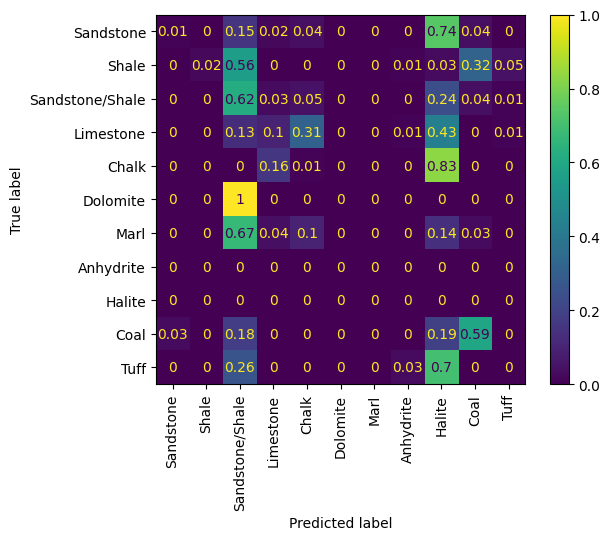

Epoch 12/100 - Training Loss: 1.55
Epoch 23/100 - Training Loss: 1.36
Epoch 34/100 - Training Loss: 1.26


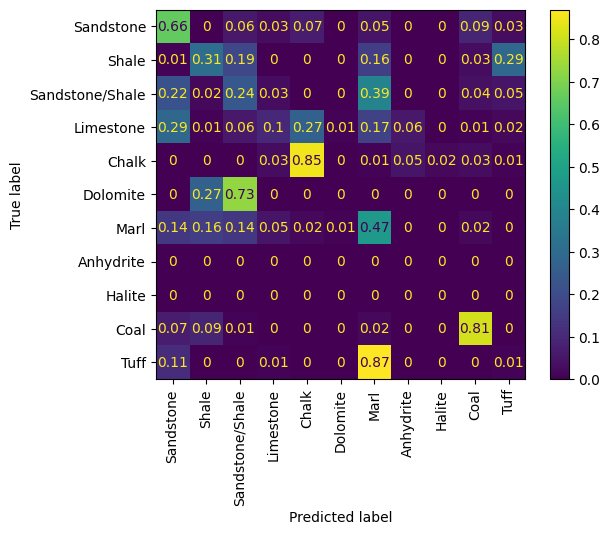

Epoch 45/100 - Training Loss: 1.21
Epoch 56/100 - Training Loss: 1.15
Epoch 67/100 - Training Loss: 1.17


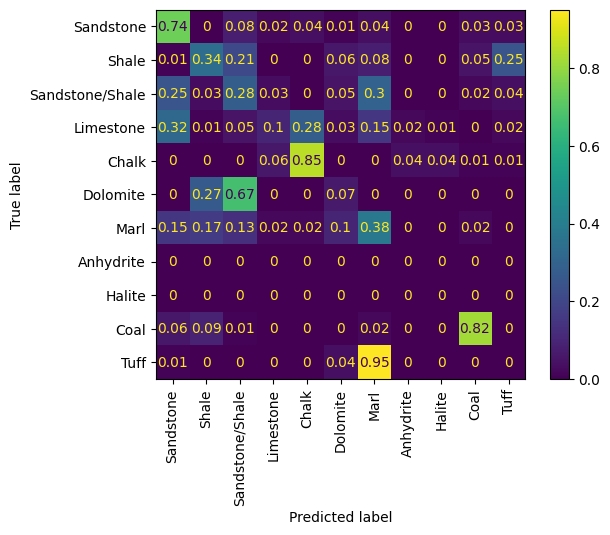

Epoch 78/100 - Training Loss: 1.13
Epoch 89/100 - Training Loss: 1.08
Epoch 100/100 - Training Loss: 1.05


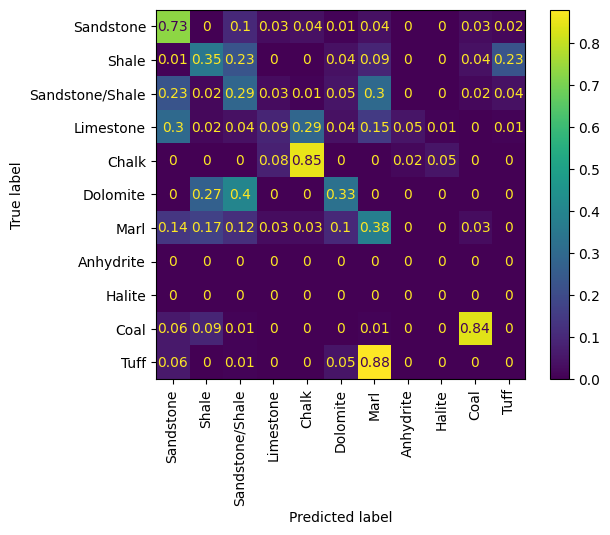

In [ ]:
for epoch in range(cfg.epochs):

    if cfg.verbose:
        print(f'Epoch {epoch+1}/{cfg.epochs}', end='\r')

    total_loss = 0
    model.train()

    for i, (wellnames, well_data_torch, labels_torch) in enumerate(train_dataloader):

        well_data_torch = well_data_torch.float().to(device)
        labels_torch = labels_torch.to(device)

        optimizer.zero_grad()

        output, hidden = model(well_data_torch)

        # Reshape to 2D tensor (batch_size * seq_len, num_classes)
        output = output.reshape(-1, cfg.num_classes)

        labels_torch = labels_torch.reshape(-1, cfg.num_classes)

        loss = criterion(output, labels_torch)
        total_loss += loss.item()

        loss.backward()

        optimizer.step()

    if cfg.verbose == True and epoch%11==0:
        print(f"Epoch {epoch+1}/{cfg.epochs} - Training Loss: {(total_loss/len(train_dataloader)):.2f}")

    if epoch%33==0:
        evaluate(model, val_dataloader)

### Avaliação final do modelo

#### Objetivo
- Executa uma avaliação final do modelo treinado no conjunto de dados de teste para avaliar seu desempenho.

#### Saída
- Imprime métricas de avaliação detalhadas e visualiza uma matriz de confusão para fornecer insights sobre o desempenho do modelo nos dados de teste.

Accuracy: 0.57
MCC: 0.41
Precision: 0.40
Recall: 0.62
F1-Score: 0.42


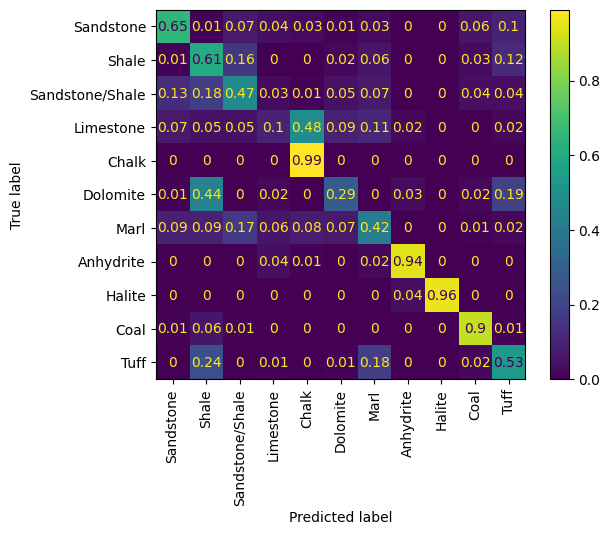

In [ ]:
evaluate(model, test_dataloader, print_metrics=True)